In [13]:
from astrotools import auger, coord, skymap
import matplotlib.pyplot as plt

# 散点图
We create an isotropic arrival map and convert galactic longitudes (lons) and galactic latitudes (lats) into cartesian vectors.

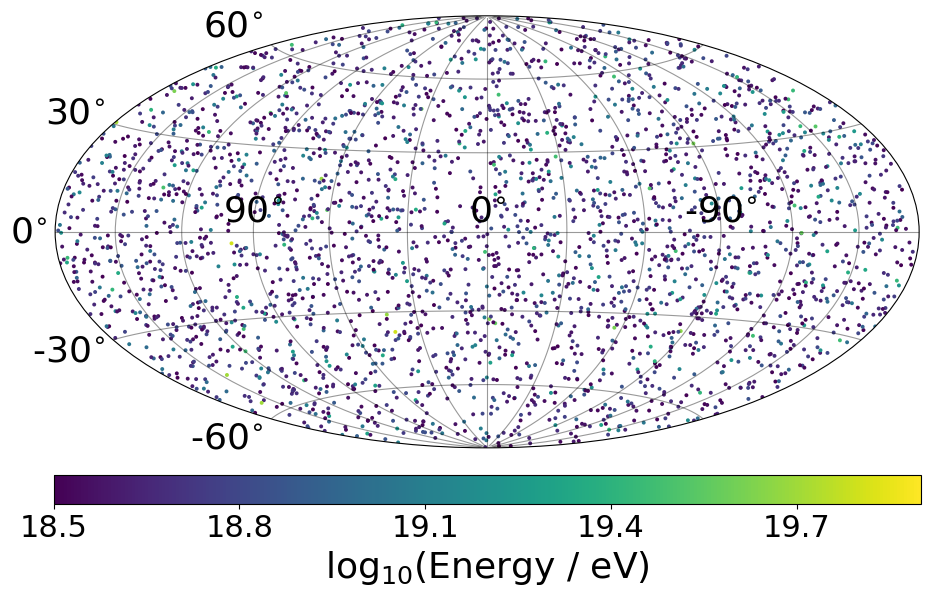

In [4]:
ncrs, emin = 3000, 18.5            # number of cosmic rays
lons = coord.rand_phi(ncrs)        # isotropic in phi (~Uniform(-pi, pi))
lats = coord.rand_theta(ncrs)      # isotropic in theta (Uniform in cos(theta))
vecs = coord.ang2vec(lons, lats)   # or better directly: coord.rand_vec(ncrs)
# Plot an example map with sampled energies. If you specify the opath keyword in
# the skymap function, the plot will be automatically saved and closed
log10e = auger.rand_energy_from_auger(n=ncrs, log10e_min=emin)
skymap.scatter(vecs, c=log10e)
plt.show()

In the following code we create an arrival map with a source located at v_src=(1, 0, 0) and apply a fisher distribution around it with gaussian spread sigma=10 degree

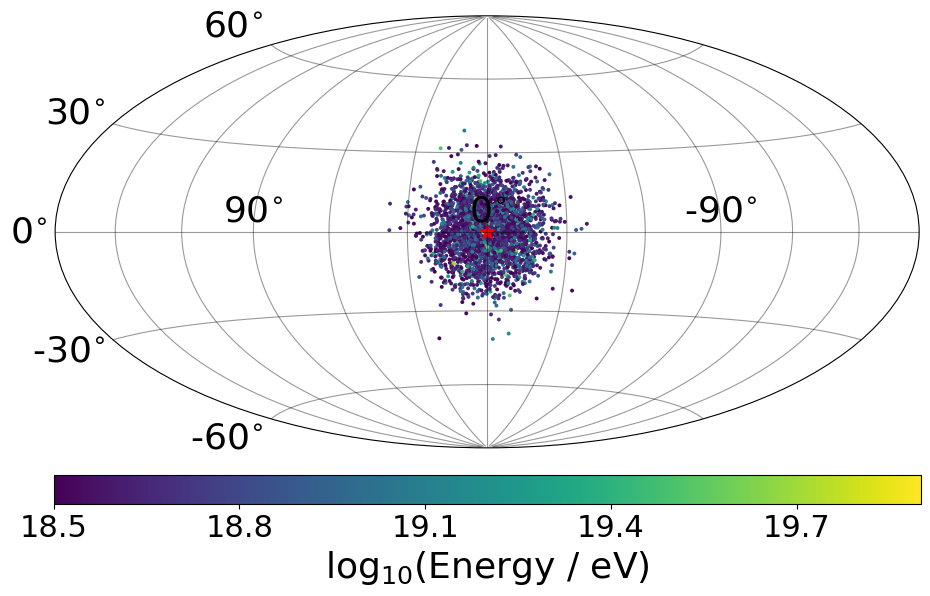

In [6]:
import numpy as np
import matplotlib.pyplot as plt
v_src = np.array([1, 0, 0])
kappa = 1. / np.radians(10.)**2
vecs = coord.rand_fisher_vec(v_src, kappa=kappa, n=ncrs)
# if you dont specify the opath you can use (fig, ax) to plot more stuff
fig, ax = skymap.scatter(vecs, c=log10e)
plt.scatter(0, 0, s=100, c='red', marker='*')    # plot source in the center
plt.savefig('fisher_single_source_10deg.png', bbox_inches='tight')
plt.show()

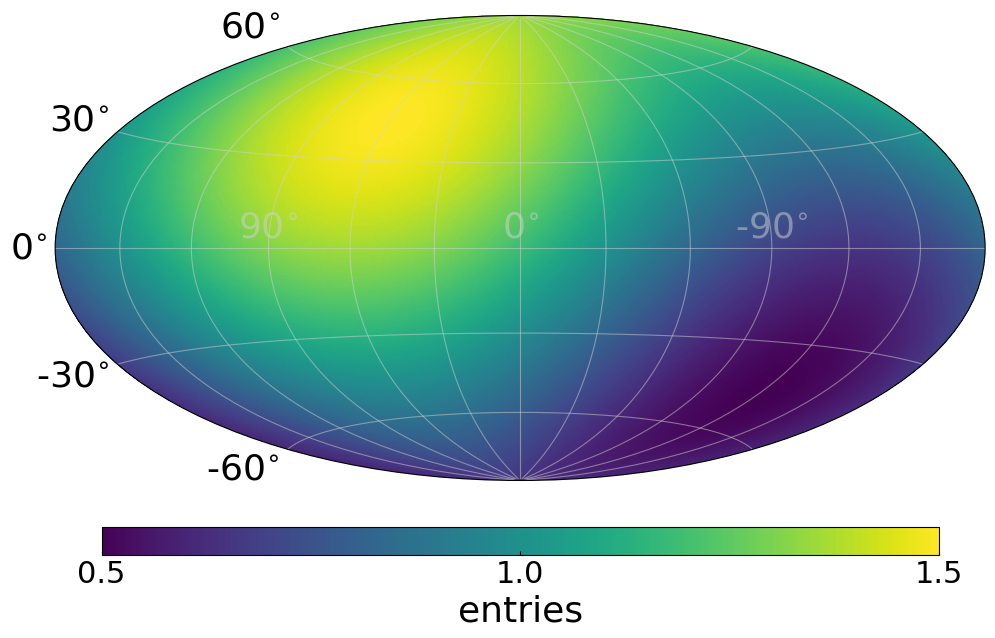

In [9]:
from astrotools import healpytools as hpt
nside = 64      # resolution of the HEALPix map (default: 64)
npix = hpt.nside2npix(nside)
nsets = 1000    # 1000 cosmic ray sets are created

lon, lat = np.radians(45), np.radians(60)   # Position of the maximum of the dipole (healpy and astrotools definition)
vec_max = hpt.ang2vec(lat, lon)             # Convert this to a vector
amplitude = 0.5                             # amplitude of dipole
dipole = hpt.dipole_pdf(nside, amplitude, vec_max, pdf=False)
skymap.heatmap(dipole)
plt.show()

/tmp/ipykernel_101382/3178698255.py:21: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  interp_func = interp2d(thetas, phis, Fs, kind='linear')
/tmp/ipykernel_101382/3178698255.py:25: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2D data.

        In new code, 

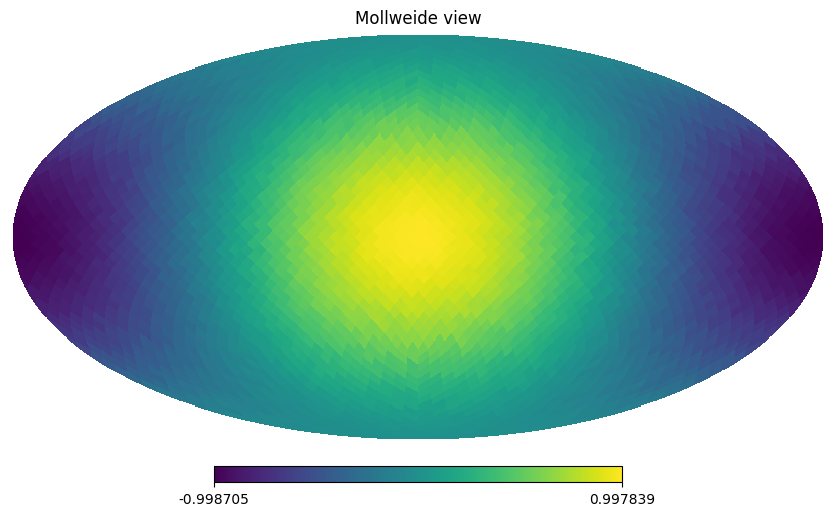

In [5]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp2d

# Set the number of sources and the coordinates for the input
nsources = 100
nside = 16
npix = hp.nside2npix(nside)

# Coordinates and the density field f
thetas = np.random.uniform(0, np.pi, nsources)
phis = np.random.uniform(0, 2*np.pi, nsources)
Thetas, Phis = np.meshgrid(thetas,phis)
Fs = np.sin(Thetas) ** 2 * np.cos(Phis)
fs = np.sin(thetas) ** 2 * np.cos(phis)
N = 200000

th = np.random.uniform(0, np.pi, N)
phi = np.random.uniform(0, 2*np.pi, N)
interp_func = interp2d(thetas, phis, Fs, kind='linear')
# fs = interp_func(th, phi)
fs = np.zeros(N)
for i in range(len(th)):
    fs[i] = interp_func(th[i], phi[i])

# fs = Fs.flatten()
# Go from HEALPix coordinates to indices
indices = hp.ang2pix(nside, th, phi)

# Initate the map and fill it with the values
hpxmap = np.zeros(npix, dtype=np.float32)
for i in range(N):
    hpxmap[indices[i]] = fs[i]

# Inspect the map
hp.mollview(hpxmap)
plt.savefig('test.png')


In [69]:
import pandas as pd
df = pd.read_csv("/mnt/e/Downloads/double-3.380.csv")
df.drop(columns=["Unnamed: 0"], inplace=True)
# df

In [70]:
import torch

In [71]:
def angle_loss_np(output, target):
    output = torch.tensor(output)
    target = torch.tensor(target)
    loss = torch.min(torch.abs(output - target), torch.abs(360 + output - target))
    return loss

In [72]:
from scipy.interpolate import LinearNDInterpolator

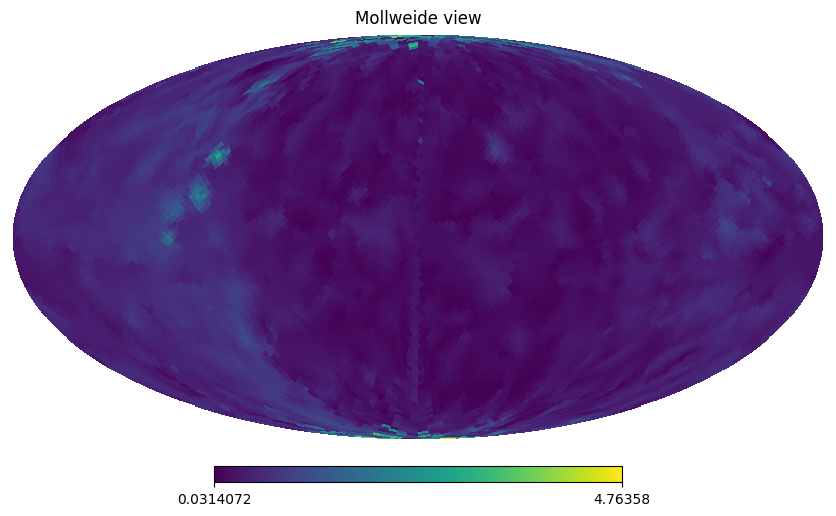

In [85]:
pred_inc = df["Pred_inc"].to_numpy()
pred_PA = df["Pred_PA"].to_numpy()
real_inc = df["Real_inc"].to_numpy()
real_PA = df["Real_PA"].to_numpy()
err_inc = np.radians(np.abs(pred_inc - real_inc))
err_PA = np.radians(angle_loss_np(pred_PA, real_PA).numpy())
error = err_inc + err_PA
nside = 32
npix = hp.nside2npix(nside)
thetas = np.radians(real_inc + 90)
thetas[thetas > np.pi] = np.pi
phis = np.radians(real_PA)
fs = error
the_phi = np.c_[thetas, phis]
lut2 = LinearNDInterpolator(the_phi, fs, fill_value=0.3)
N = 500000
Theta = np.random.uniform(0, np.pi, N)
Phi = np.random.uniform(0, 2*np.pi, N)
Fs = lut2(Theta, Phi)

indices = hp.ang2pix(nside, Theta, Phi)
hpxmap = np.zeros(npix, dtype=np.float32)
for i in range(N):
    hpxmap[indices[i]] = Fs[i]
hp.mollview(hpxmap)
plt.savefig(f'fits.png')

In [41]:
df_all = pd.DataFrame({'thetas': thetas, 'phis': phis, 'fs': fs})
df_all.set_index('thetas', inplace=True)
# df_all.unstack()
df_all

,phis,fs
thetas,,
0.568977,1.946156,2.443263
1.685988,4.285239,0.699697
0.422370,0.418925,0.199946
1.466077,4.313688,1.147623
2.832669,2.219134,1.214581
...,...,...
2.389356,6.040944,0.128297
0.136136,2.715366,2.082345
0.918043,3.483108,1.124812


In [34]:
df_pivot = pd.pivot_table(df_all, values='fs', index='thetas', columns='phis')

1802

In [42]:
# thetas = df_pivot.index.to_numpy()
# phis = df_pivot.columns.to_numpy()
# Fs = df_pivot.values
# Fs

In [36]:
# func = interp2d(thetas, phis, Fs.T, kind='linear')

In [123]:
from scipy.interpolate import LinearNDInterpolator, NearestNDInterpolator

class LinearNDInterpolatorExt(object):
  def __init__(self, points,values):
    self.funcinterp = LinearNDInterpolator(points,values)
    self.funcnearest = NearestNDInterpolator(points,values)
  def __call__(self,*args):
    t = self.funcinterp(*args)
    if not np.isnan(t):
      return t.item(0)
    else:
      return self.funcnearest(*args)

In [1]:
the_phi = np.c_[thetas, phis]
lut2 = LinearNDInterpolatorExt(the_phi, fs)
t = np.linspace(0, np.pi, 100)
p = np.linspace(0, 2*np.pi, 100)
Theta, Phi = np.meshgrid(t, p)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
interpolate_points = np.zeros_like(Theta)
for i in range(len(t)):
    for j in range(len(p)):
        interpolate_points[j, i] = lut2(t[i], p[j])
ax.plot_wireframe(Theta, Phi, interpolate_points)
ax.scatter(thetas, phis, fs,  'o', color='k', s=48)

NameError: name 'np' is not defined

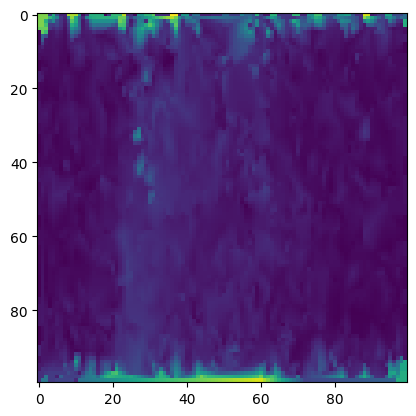

In [131]:
plt.imshow(interpolate_points)

In [132]:
lut2(0, 0)

4.4376128182695505